# Object Localization with TensorFlow

Created for the Coursera Guided Project: [Object Localization with TensorFlow](https://www.coursera.org/projects/object-localization-tensorflow)

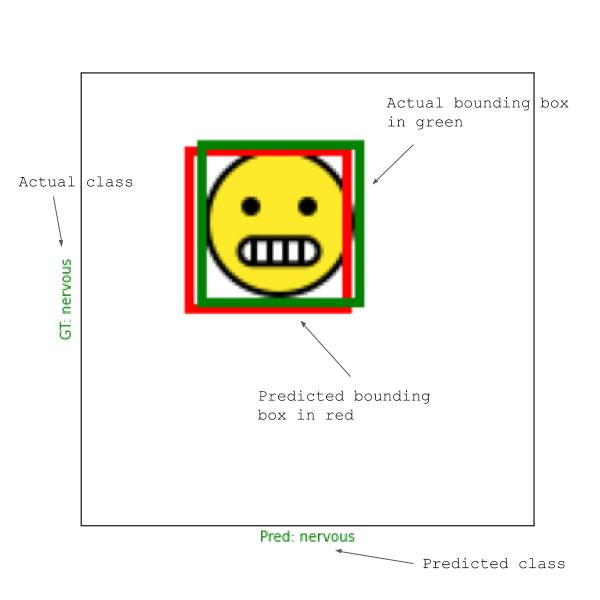

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/objectlocalization

/content/drive/MyDrive/objectlocalization


## Task 2: Download and Visualize Data

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.4.0


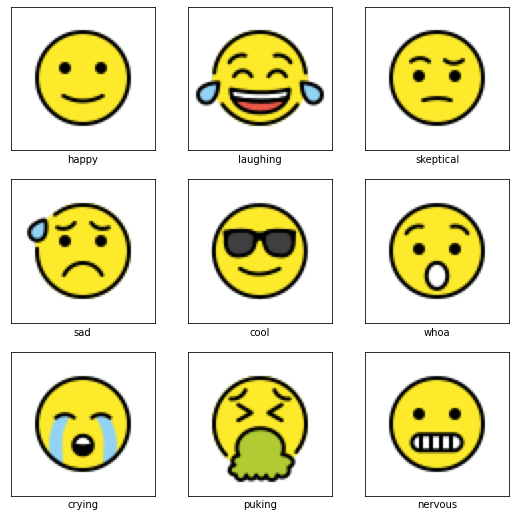

In [ ]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

In [ ]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [ ]:
emojis

{0: {'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B555FAD0>,
  'name': 'happy'},
 1: {'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54EFFD0>,
  'name': 'laughing'},
 2: {'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54EB610>,
  'name': 'skeptical'},
 3: {'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54EFBD0>,
  'name': 'sad'},
 4: {'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B7CBE650>,
  'name': 'cool'},
 5: {'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54F9A50>,
  'name': 'whoa'},
 6: {'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54F9650>,
  'name': 'crying'},
 7: {'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F47B54F9A10>,
  'name': 'puking'},
 8: {'file': '1F62C.png',
  'image'

In [ ]:
def create_example():
  class_id=np.random.randint(0,9)
  image=np.ones((144,144,3))*255
  row = np.random.randint(0,72)
  col =np.random.randint(0,72)
  image[row: row+72, col:col+72,:] = np.array(emojis[class_id]["image"])
  return image.astype('uint8'), class_id, (row +10)/144,(col+10)/144

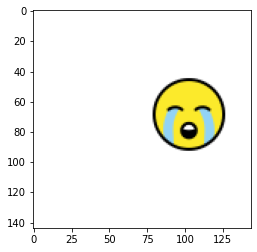

In [ ]:
image, class_id,row,col=create_example()
plt.imshow(image)

## Task 4: Plot Bounding Boxes

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords=[] ,norm=False):
  if norm:
    image*=255.
    image =image.astype('uint8')
  image = Image.fromarray(image)
  draw=ImageDraw.Draw(image)

  row,col=gt_coords
  row *= 144
  col *=144
  draw.rectangle((col,row,col+52,row+52), outline='green',width=3)

  if len(pred_coords) ==2:
    row,col=pred_coords
    row*=144
    col*=144
    draw.rectangle((col,row,col+52,row+52),outline="red",width=3)
  return image

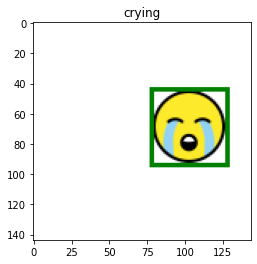

In [ ]:
image = plot_bounding_box(image, gt_coords=[row,col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 5: Data Generator

In [ ]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size,144,144,3))
    y_batch=np.zeros((batch_size,9))
    bbox_batch=np.zeros((batch_size,2))

    for i in range(0,batch_size):
      image,class_id,row,col = create_example()
      x_batch[i]=image/255.
      y_batch[i,class_id]=1.0
      bbox_batch[i]=np.array([row,col])
    yield {"image" : x_batch}, {"class_out":y_batch, "box_out":bbox_batch}

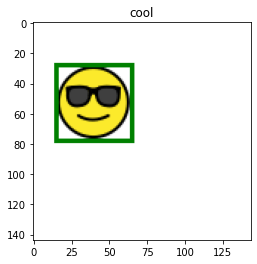

In [ ]:
example,label=next(data_generator(1))
image=example["image"][0]
class_id=np.argmax(label["class_out"][0])
coords=label["box_out"][0]

image=plot_bounding_box(image ,coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]["name"])
plt.show()

## Task 6: Model

In [ ]:
input_=Input(shape=[144,144,3],name='image')

x=input_

for i in range(0,5):
  n_filters=2**(4+i)
  x=Conv2D(n_filters,3,activation="relu")(x)
  x=BatchNormalization()(x)
  x=MaxPool2D(2)(x)

x=Flatten()(x)
x=Dense(256,activation='relu')(x)

class_out=Dense(9,activation="softmax", name="class_out")(x)
box_out=Dense(2,name="box_out")(x)

model=tf.keras.models.Model(input_,[class_out,box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Task 7: Custom Metric: IoU

In [ ]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU,self).__init__(**kwargs)

    self.iou = self.add_weight(name="iou", initializer="zeros")
    self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
    self.num_ex=self.add_weight(name="num_ex", initializer="zeros")

  def update_state(self,y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows,cols=y[:,0], y[:,1]
      rows,cols = rows*144, cols*144
      y1, y2 = rows, rows+ 52
      x1, x2 = cols, cols +52
      return x1, y1, x2, y2

    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area= get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou=tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou =tf.math.divide(self.total_iou, self.num_ex)

  def result(self):
    return self.iou

  def reset_state(self):
      self.iou = self.add_weight(name="iou", initializer="zeros")
      self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
      self.num_ex =self.add_weight(name="num_ex", initializer="zeros")

## Task 8: Compile the Model

In [ ]:
model.compile(
    loss={
        'class_out': "categorical_crossentropy",
        'box_out' : "mse"
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out':'accuracy',
        'box_out':IoU(name='iou')
    }
)

## Task 9: Custom Callback: Model Testing

In [ ]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x= example['image']
  y=label['class_out']
  box=label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords=box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm =True)
  color = "green" if gt ==pred_class_name else "red"


  plt.imshow(image)
  plt.xlabel(f'Pred:{pred_class_name}',color=color)
  plt.ylabel(f'GT: {gt}' , color=color)
  plt.xticks([])
  plt.yticks([])

In [ ]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(16,4))

  for i in range(0,6):
    plt.subplot(1,6,i+1)
    test_model(model,test_datagen)
  plt.show()

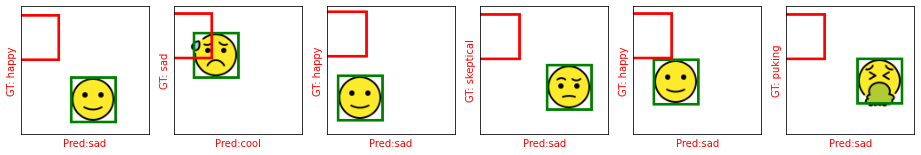

In [ ]:
test(model)

In [ ]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

## Task 10: Model Training

Epoch 1/50
500/500 [==============================] - 14s 24ms/step - loss: 2.5748 - class_out_loss: 1.6025 - box_out_loss: 0.9723 - class_out_accuracy: 0.4437 - box_out_iou: 0.1699


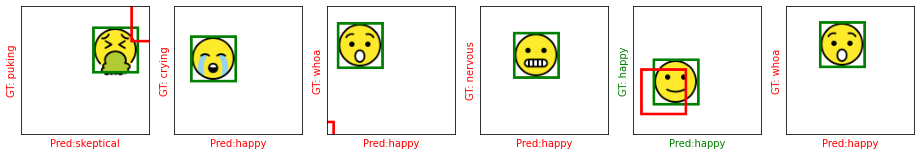

Epoch 2/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0486 - class_out_loss: 0.0154 - box_out_loss: 0.0332 - class_out_accuracy: 0.9994 - box_out_iou: 0.2834


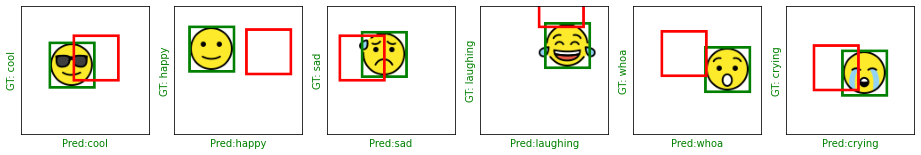

Epoch 3/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0212 - class_out_loss: 0.0064 - box_out_loss: 0.0148 - class_out_accuracy: 0.9994 - box_out_iou: 0.4097


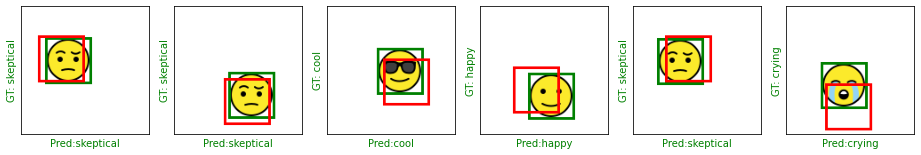

Epoch 4/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0086 - class_out_loss: 0.0016 - box_out_loss: 0.0070 - class_out_accuracy: 1.0000 - box_out_iou: 0.5278


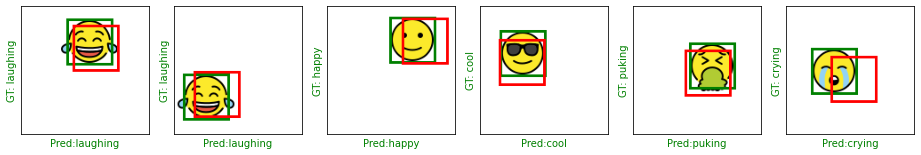

Epoch 5/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0040 - class_out_loss: 0.0010 - box_out_loss: 0.0030 - class_out_accuracy: 1.0000 - box_out_iou: 0.6559


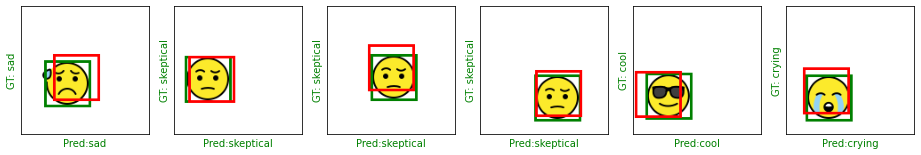

Epoch 6/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0031 - class_out_loss: 8.3207e-04 - box_out_loss: 0.0023 - class_out_accuracy: 1.0000 - box_out_iou: 0.6855


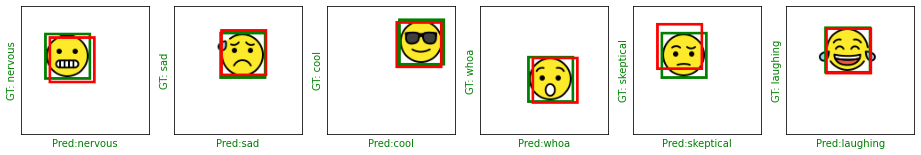

Epoch 7/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0026 - class_out_loss: 5.4744e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.6951


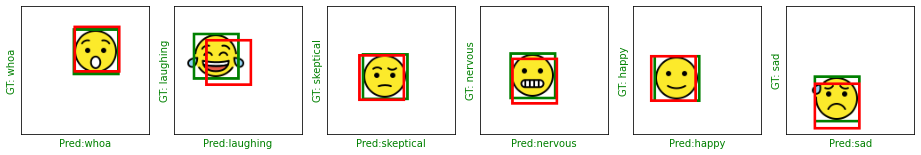

Epoch 8/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0062 - class_out_loss: 0.0037 - box_out_loss: 0.0025 - class_out_accuracy: 0.9985 - box_out_iou: 0.6736


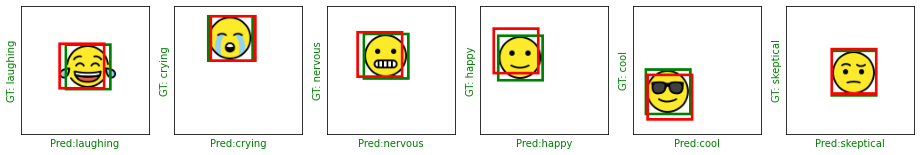

Epoch 9/50
500/500 [==============================] - 13s 25ms/step - loss: 0.0025 - class_out_loss: 5.0985e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 0.6995


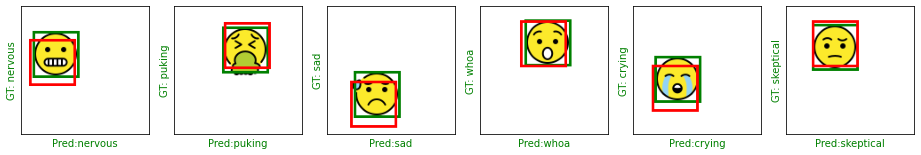

Epoch 10/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0019 - class_out_loss: 4.6671e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.7391


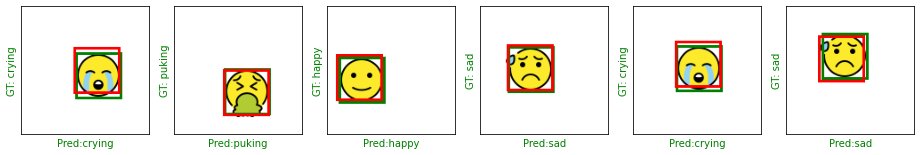

Epoch 11/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0016 - class_out_loss: 3.4510e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7504


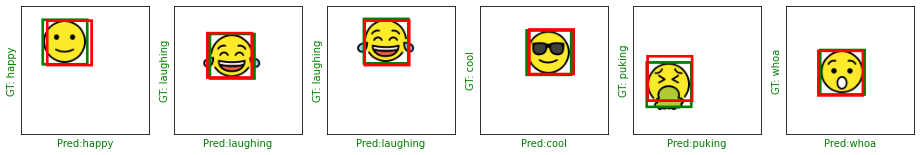

Epoch 12/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0016 - class_out_loss: 3.3571e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7517


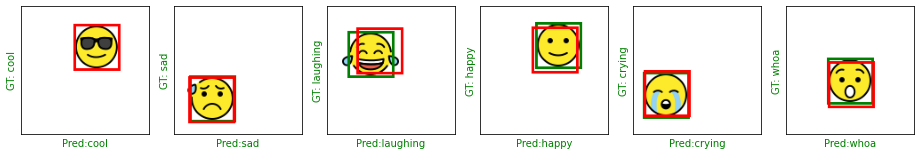

Epoch 13/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0016 - class_out_loss: 3.7861e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7571


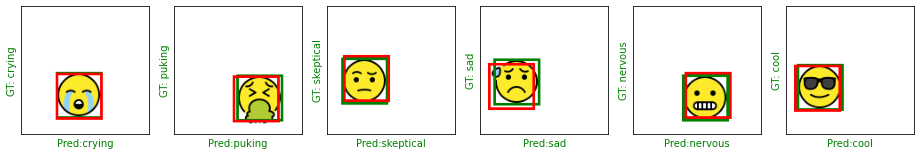

Epoch 14/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0015 - class_out_loss: 2.9743e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7574


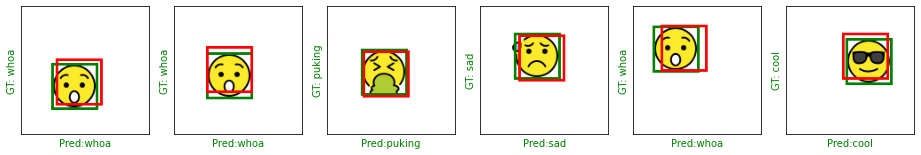

Epoch 15/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0014 - class_out_loss: 3.0471e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7681


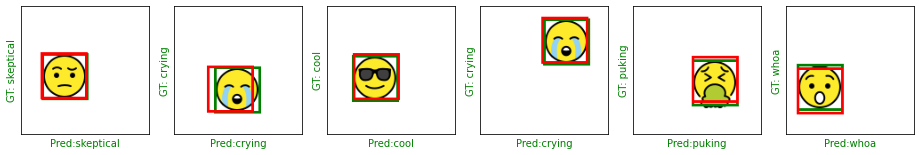

Epoch 16/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0016 - class_out_loss: 5.8011e-04 - box_out_loss: 0.0010 - class_out_accuracy: 0.9999 - box_out_iou: 0.7727


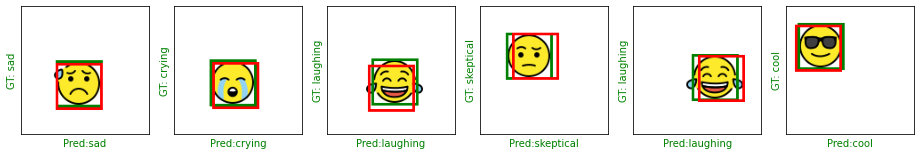

Epoch 17/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0012 - class_out_loss: 2.7383e-04 - box_out_loss: 9.5912e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7790


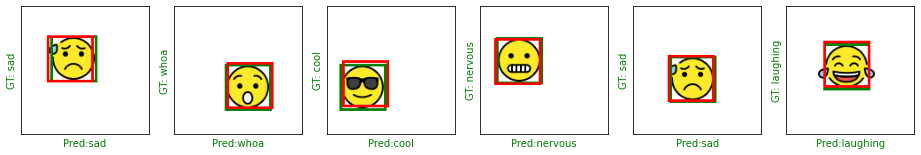

Epoch 18/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0013 - class_out_loss: 2.9980e-04 - box_out_loss: 9.6557e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7781


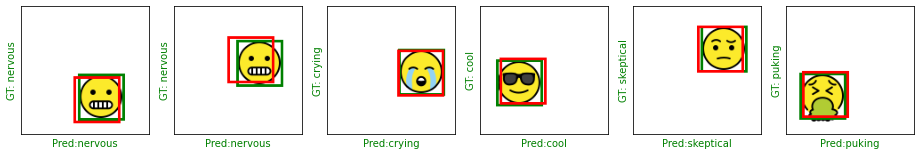

Epoch 19/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0012 - class_out_loss: 2.6784e-04 - box_out_loss: 9.7411e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7766


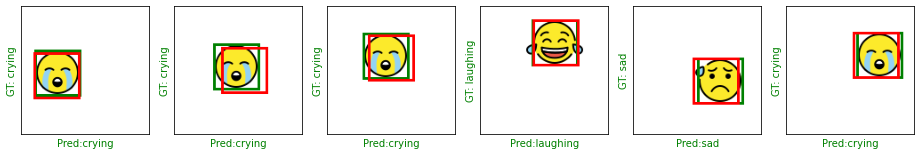

Epoch 20/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0011 - class_out_loss: 2.0469e-04 - box_out_loss: 8.8416e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7849


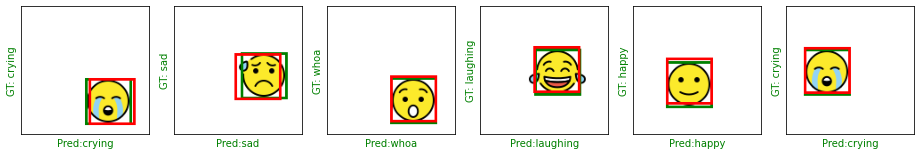

Epoch 21/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0012 - class_out_loss: 2.4380e-04 - box_out_loss: 9.1291e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7833


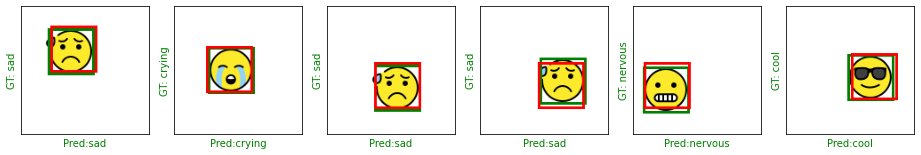

Epoch 22/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.2001e-04 - box_out_loss: 8.6561e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7862


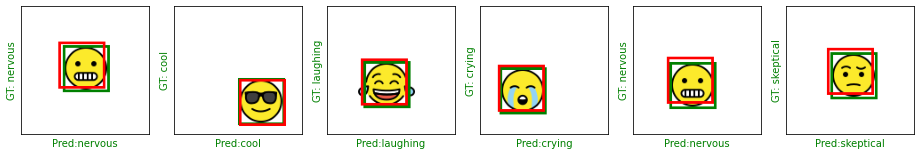

Epoch 23/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.4140e-04 - box_out_loss: 9.0548e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7824


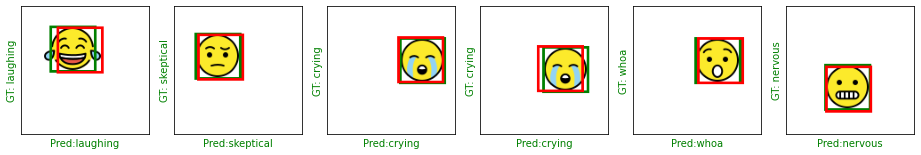

Epoch 24/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.4687e-04 - box_out_loss: 9.0022e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7837


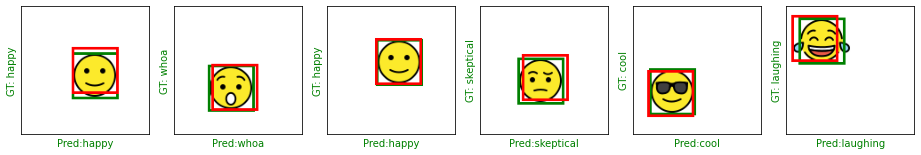

Epoch 25/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0012 - class_out_loss: 2.8577e-04 - box_out_loss: 8.8139e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7865


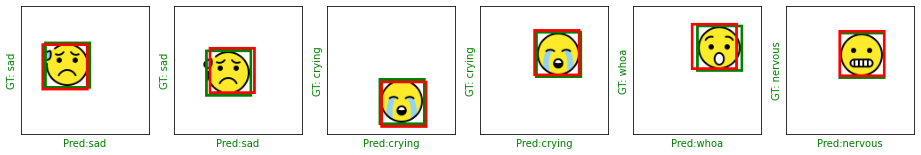

Epoch 26/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0011 - class_out_loss: 2.0394e-04 - box_out_loss: 8.4820e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7896


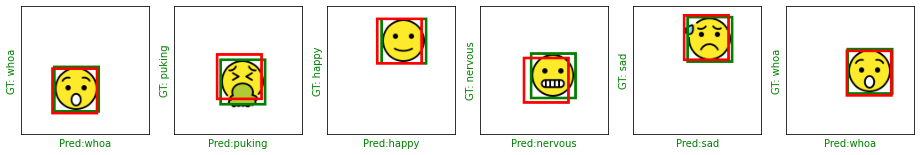

Epoch 27/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0012 - class_out_loss: 3.1945e-04 - box_out_loss: 8.6503e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7884


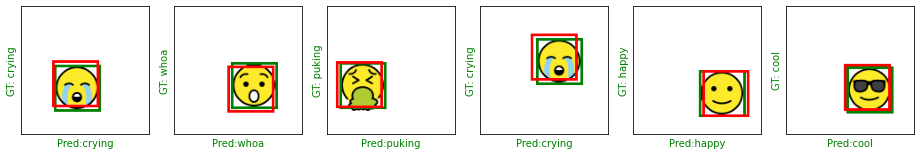

Epoch 28/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0010 - class_out_loss: 2.1014e-04 - box_out_loss: 8.1724e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7920


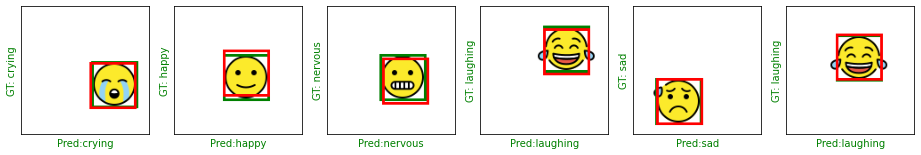

Epoch 29/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0012 - class_out_loss: 3.2835e-04 - box_out_loss: 8.8651e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7857


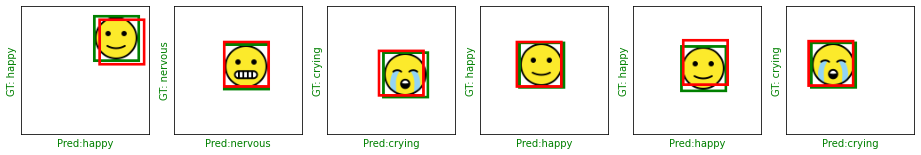

Epoch 30/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0011 - class_out_loss: 2.4041e-04 - box_out_loss: 8.9738e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7840


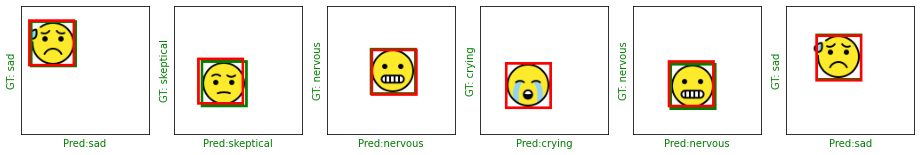

Epoch 31/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0011 - class_out_loss: 2.2801e-04 - box_out_loss: 8.2491e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7904


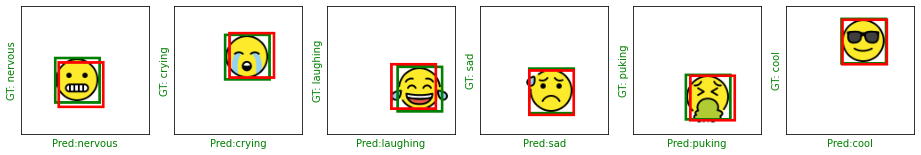

Epoch 32/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0011 - class_out_loss: 2.3745e-04 - box_out_loss: 8.6700e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7871


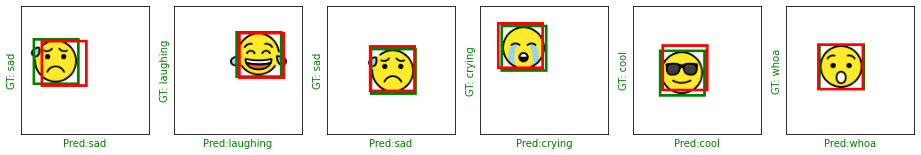

Epoch 33/50
500/500 [==============================] - 14s 29ms/step - loss: 0.0011 - class_out_loss: 2.5392e-04 - box_out_loss: 8.2828e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7906


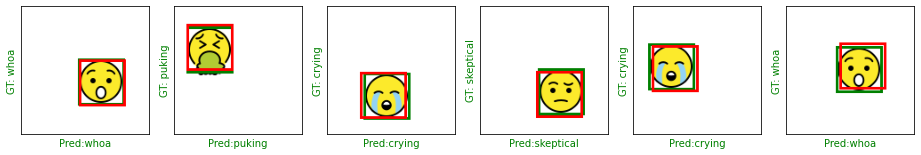

Epoch 34/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0011 - class_out_loss: 2.0831e-04 - box_out_loss: 8.4324e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7899


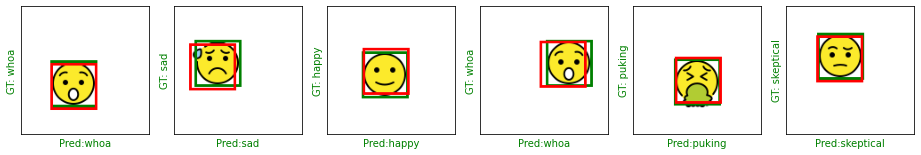

Epoch 35/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0010 - class_out_loss: 2.1608e-04 - box_out_loss: 8.3312e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7910


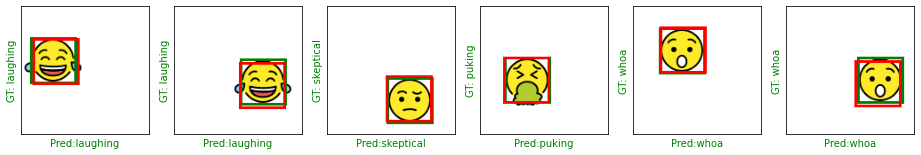

Epoch 36/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0010 - class_out_loss: 2.1347e-04 - box_out_loss: 8.2078e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7925


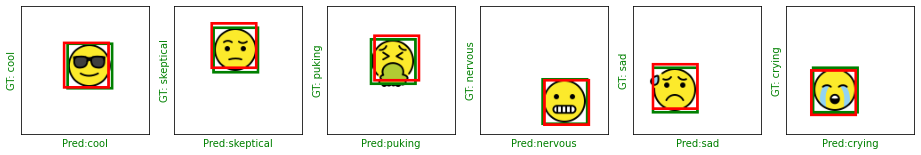

Epoch 37/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0011 - class_out_loss: 2.7430e-04 - box_out_loss: 8.4117e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7903


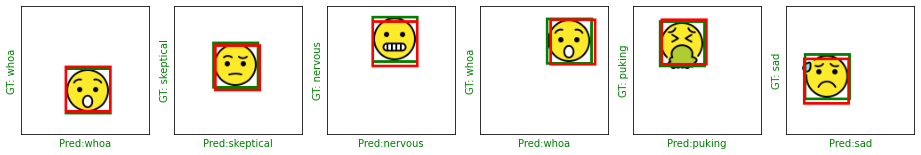

Epoch 38/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0011 - class_out_loss: 2.3467e-04 - box_out_loss: 8.4893e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7905


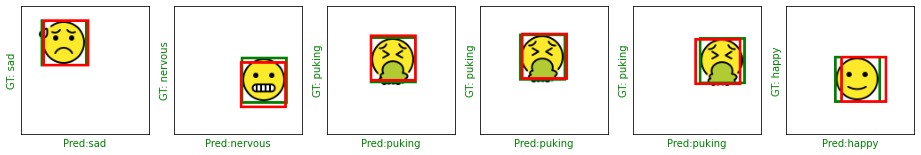

Epoch 39/50
500/500 [==============================] - 15s 31ms/step - loss: 0.0011 - class_out_loss: 2.5583e-04 - box_out_loss: 8.4336e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7898


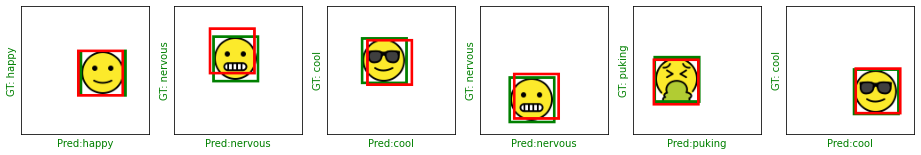

Epoch 40/50
500/500 [==============================] - 15s 30ms/step - loss: 9.8979e-04 - class_out_loss: 1.9478e-04 - box_out_loss: 7.9501e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7946


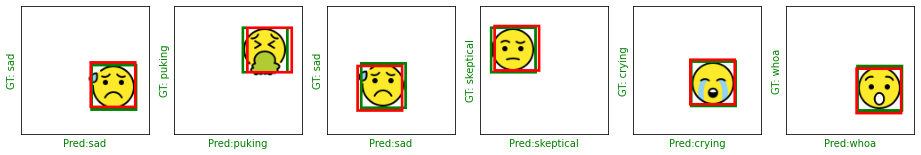

Epoch 41/50
500/500 [==============================] - 15s 31ms/step - loss: 0.0012 - class_out_loss: 3.8469e-04 - box_out_loss: 8.2995e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.7915


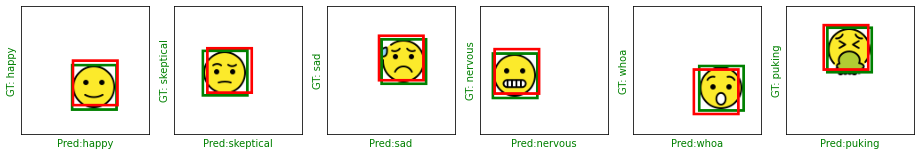

Epoch 42/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0010 - class_out_loss: 2.1277e-04 - box_out_loss: 8.1120e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7923


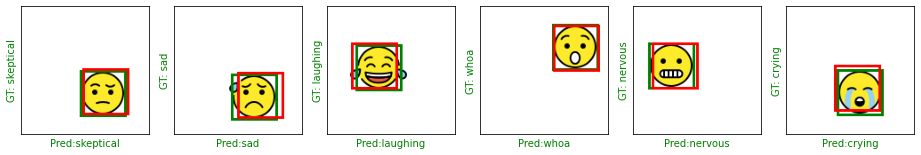

Epoch 43/50
500/500 [==============================] - 15s 31ms/step - loss: 9.9506e-04 - class_out_loss: 1.8582e-04 - box_out_loss: 8.0924e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7935


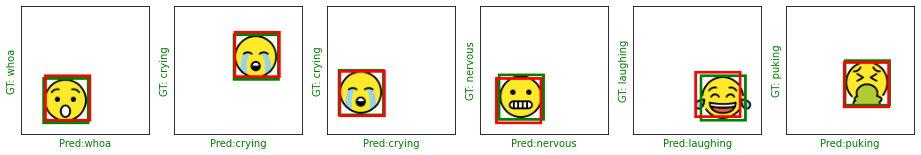

In [ ]:
def lr_schedule(epoch,lr):
  if (epoch +1) % 5 == 0:
    lr*=0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
              ShowTestImages(),
              tf.keras.callbacks.EarlyStopping(monitor="box_out_iou", patience=3, mode ="max"),
              tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)